In [2]:
import pandas as pd
import nltk
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification

c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_table(
    "../datasets/CREMA-D/text/train.txt",
    delimiter=";",
    header=None,
)

val = pd.read_table(
    "../datasets/CREMA-D/text/val.txt",
    delimiter=";",
    header=None,
)

test = pd.read_table(
    "../datasets/CREMA-D/text/test.txt",
    delimiter=";",
    header=None,
)

train.columns = ["Text", "Emotion"]
val.columns = ["Text", "Emotion"]
test.columns = ["Text", "Emotion"]

# print("Train head:", train.head())
# print("Train shape:", train.shape)
# print("-" * 10)
# print("Val head:", val.head())
# print("Val shape:", val.shape)
# print("-" * 10)
# print("Test head:", test.head())
# print("Test shape:", test.shape)
# print("-" * 10)

data = pd.concat([train, val, test], ignore_index=True)
data.columns = ["text", "label"]

# print("Data head:", data.head())
print("Data shape:", data.shape)

Data shape: (20000, 2)


In [4]:
data.isna().any(axis=1).sum()

0

In [5]:
nltk.download("stopwords")

import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


def preprocess(line):
    review = re.sub("[^a-zA-Z]", " ", line)
    review = review.lower()
    review = review.split()

    # apply Stemming + remove the stopwords
    review = [
        PorterStemmer().stem(word)
        for word in review
        if not word in stopwords.words("english")
    ]

    return " ".join(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
print(train.columns)
print(val.columns)
print(test.columns)

Index(['Text', 'Emotion'], dtype='object')
Index(['Text', 'Emotion'], dtype='object')
Index(['Text', 'Emotion'], dtype='object')


In [10]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def preprocess_with_lemmatization(line):
    review = re.sub("[^a-zA-Z]", " ", line)
    review = review.lower()
    review = review.split()

    # Apply lemmatization and remove stopwords
    review = [
        lemmatizer.lemmatize(word)
        for word in review
        if not word in stopwords.words("english")
    ]

    return " ".join(review)

train["text"] = train["Text"].apply(lambda x: preprocess_with_lemmatization(x))
val["text"] = val["Text"].apply(lambda x: preprocess_with_lemmatization(x))
test["text"] = test["Text"].apply(lambda x: preprocess_with_lemmatization(x))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
from collections import Counter

# Combine all text data
all_text = " ".join(train["text"].tolist() + val["text"].tolist() + test["text"].tolist())
word_freq = Counter(all_text.split())

# Remove rare words
threshold = 2  # Words with frequency < 2 will be removed
train["text"] = train["text"].apply(
    lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold])
)
val["text"] = val["text"].apply(
    lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold])
)
test["text"] = test["text"].apply(
    lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold])
)


In [12]:
# Preprocess training, validation, and test datasets
train["text"] = train["Text"].apply(lambda x: preprocess(x))
val["text"] = val["Text"].apply(lambda x: preprocess(x))
test["text"] = test["Text"].apply(lambda x: preprocess(x))

# Encode labels for training, validation, and test sets
label_encoder = preprocessing.LabelEncoder()
train["N_label"] = label_encoder.fit_transform(train["Emotion"])
val["N_label"] = label_encoder.transform(val["Emotion"])  # Use the same encoder
test["N_label"] = label_encoder.transform(test["Emotion"])  # Use the same encoder

# Text Classification Using CNN

This guide outlines the process of using a Convolutional Neural Network (CNN) for text classification, from preprocessing to evaluation.

---

## Workflow Summary:

### 1. **Tokenize and Pad Sequences**
- **Tokenization**: Converts text into numerical indices.
- **Padding**: Ensures all sequences are of equal length for model compatibility.

---

### 2. **Building the CNN Model**
Key components:
- **Embedding Layer**: Maps words to dense vector representations.
- **Convolutional Layers**: Extract patterns (e.g., n-grams) from text.
- **Pooling Layers**: Downsample features to reduce dimensionality.
- **Dropout Layers**: Prevent overfitting by dropping random inputs during training.
- **Fully Connected Layers**: Perform final classification with probabilities for each class.

---

### 3. **Training the Model**
- **Training Data**: Used for learning weights.
- **Validation Data**: Evaluates performance during training.
- **Epochs**: Number of complete passes through the data.
- **Batch Size**: Determines the number of samples processed at a time.

---

### 4. **Model Evaluation**
- Evaluate the model's generalization on the test dataset.
- Calculate metrics like accuracy and generate predictions.

---

### 5. **Visualizing Results**
- **Confusion Matrix**: Visualize predicted vs actual labels.
- **Classification Report**: Summarizes precision, recall, and F1-score.
- **Training Metrics**: Plots of accuracy and loss for both training and validation.

---

## Summary
CNNs are highly effective for text classification, leveraging embedding layers and convolutional layers to detect meaningful patterns. This approach is suitable for tasks like sentiment analysis, topic categorization, and emotion detection.

Epoch 1/10
500/500 [==============================] - 23s 43ms/step - loss: 1.1563 - accuracy: 0.5562 - val_loss: 0.5490 - val_accuracy: 0.8110
Epoch 2/10
500/500 [==============================] - 23s 47ms/step - loss: 0.3662 - accuracy: 0.8780 - val_loss: 0.2835 - val_accuracy: 0.8965
Epoch 3/10
500/500 [==============================] - 23s 46ms/step - loss: 0.2014 - accuracy: 0.9323 - val_loss: 0.2824 - val_accuracy: 0.9025
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1387 - accuracy: 0.9509 - val_loss: 0.3020 - val_accuracy: 0.9015
Epoch 5/10
500/500 [==============================] - 25s 49ms/step - loss: 0.1068 - accuracy: 0.9646 - val_loss: 0.3128 - val_accuracy: 0.9105
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0937 - accuracy: 0.9672 - val_loss: 0.3195 - val_accuracy: 0.8995
Epoch 7/10
500/500 [==============================] - 23s 46ms/step - loss: 0.0774 - accuracy: 0.9741 - val_loss: 0.3768 - val_accuracy:

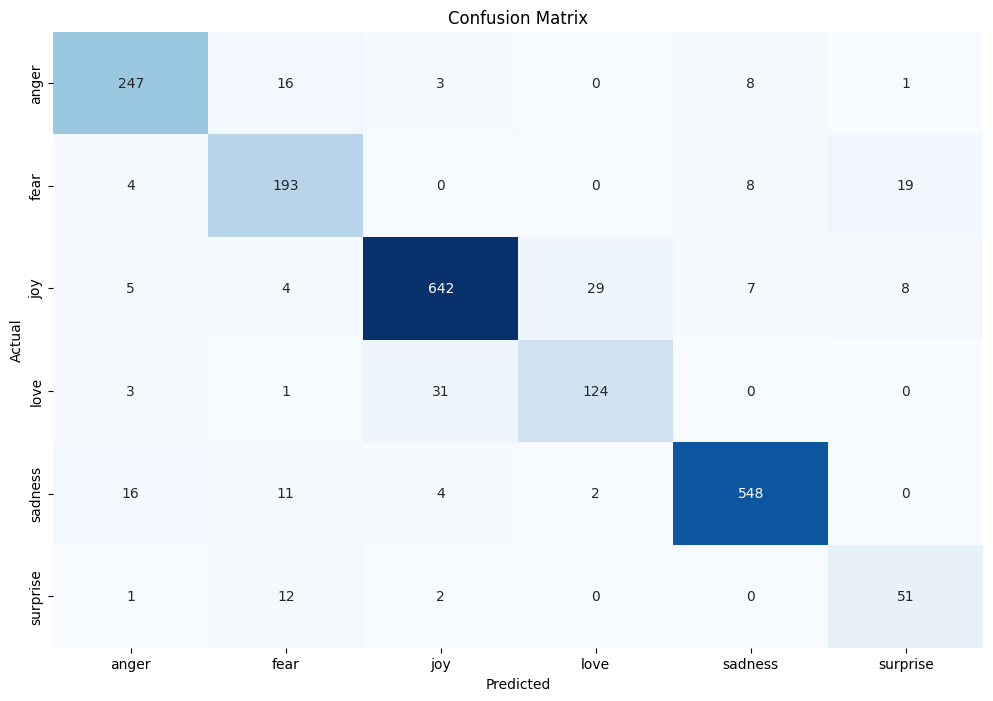

              precision    recall  f1-score   support

       anger       0.89      0.90      0.90       275
        fear       0.81      0.86      0.84       224
         joy       0.94      0.92      0.93       695
        love       0.80      0.78      0.79       159
     sadness       0.96      0.94      0.95       581
    surprise       0.65      0.77      0.70        66

    accuracy                           0.90      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.91      0.90      0.90      2000



In [38]:
# Tokenize and pad sequences
max_len = 100  # Maximum sequence length
tokenizer = Tokenizer(num_words=5000)  # Use the top 5000 words
tokenizer.fit_on_texts(train["text"])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train["text"])
X_val = tokenizer.texts_to_sequences(val["text"])
X_test = tokenizer.texts_to_sequences(test["text"])

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train = np.array(train["N_label"])
y_val = np.array(val["N_label"])
y_test = np.array(test["N_label"])

# Build the CNN model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# Convolutional layers
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Predict on the test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



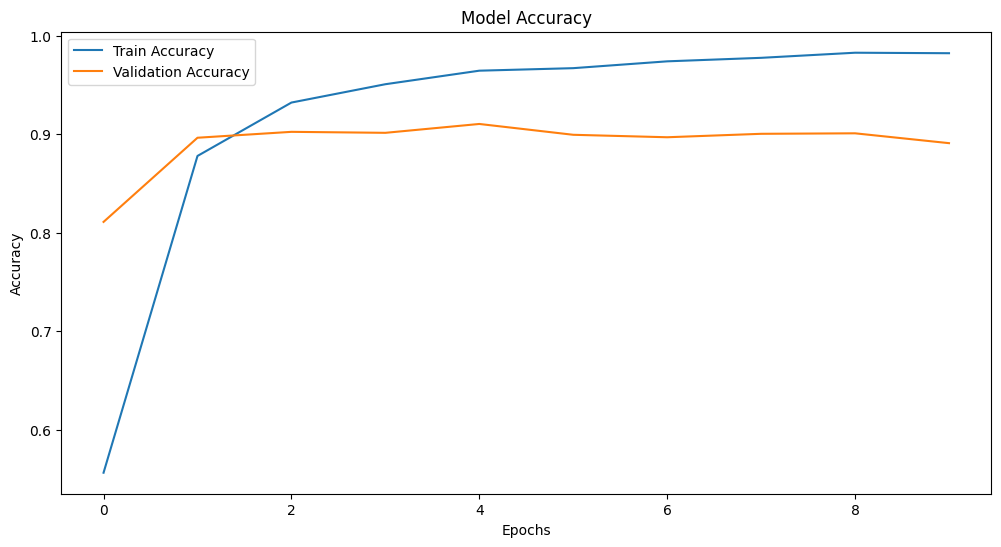

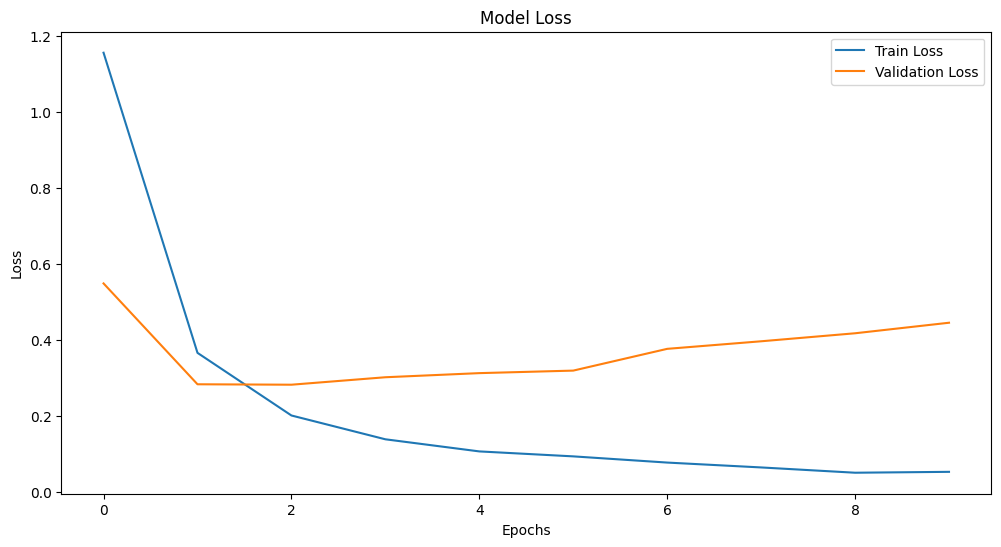

In [40]:

# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [39]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


63/63 [==============================] - 1s 9ms/step - loss: 0.3631 - accuracy: 0.9025
Test Accuracy: 90.25%


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
model.add(Conv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # l2 regularization
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
500/500 [==============================] - 39s 76ms/step - loss: 2.5176 - accuracy: 0.3227 - val_loss: 1.8518 - val_accuracy: 0.3520 - lr: 1.0000e-04
Epoch 2/10
500/500 [==============================] - 32s 64ms/step - loss: 1.7202 - accuracy: 0.3244 - val_loss: 1.6483 - val_accuracy: 0.3520 - lr: 1.0000e-04
Epoch 3/10
500/500 [==============================] - 34s 68ms/step - loss: 1.4005 - accuracy: 0.4559 - val_loss: 1.0462 - val_accuracy: 0.6545 - lr: 1.0000e-04
Epoch 4/10
500/500 [==============================] - 34s 69ms/step - loss: 0.8426 - accuracy: 0.6986 - val_loss: 0.7522 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 5/10
500/500 [==============================] - 35s 69ms/step - loss: 0.6208 - accuracy: 0.7692 - val_loss: 0.6337 - val_accuracy: 0.7975 - lr: 1.0000e-04
Epoch 6/10
500/500 [==============================] - 35s 69ms/step - loss: 0.5055 - accuracy: 0.8128 - val_loss: 0.5674 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 7/10
500/500 [==============

## RNN MODEL##

In [22]:
# Build the RNN-based model
model = Sequential(name="Text_Emotion_RNN")

# Embedding Layer
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# RNN Layers
model.add(SimpleRNN(128, return_sequences=True, activation="tanh"))
model.add(Dropout(0.3))
model.add(SimpleRNN(64, activation="tanh"))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation="softmax"))

# Compile the Model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Model Summary
model.summary()

# Learning Rate Reduction
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

# Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on Test Data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Model: "Text_Emotion_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 128)          32896     
                                                                 
 dropout_9 (Dropout)         (None, 100, 128)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)           

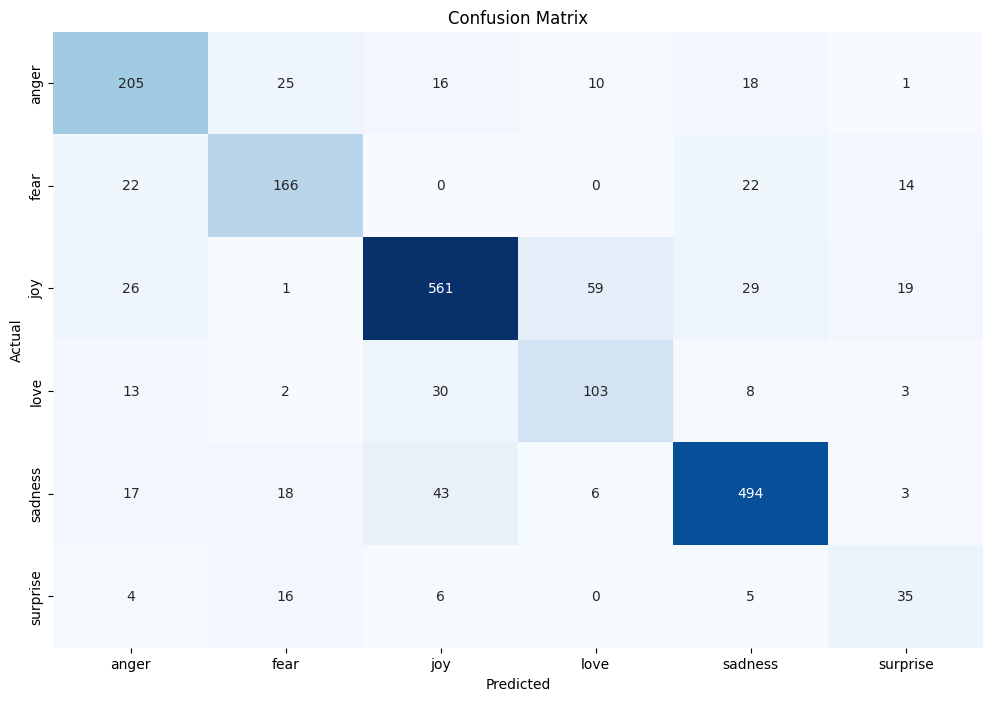

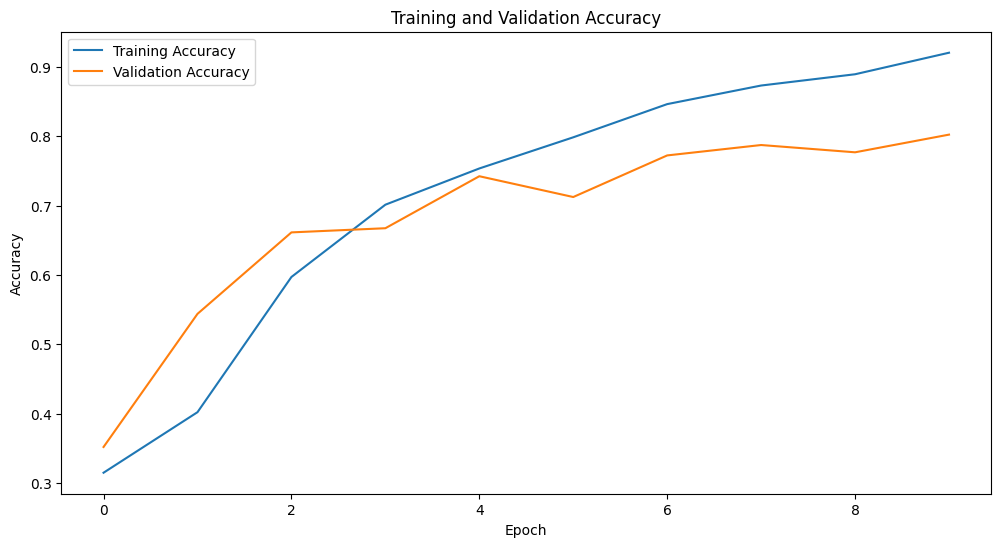

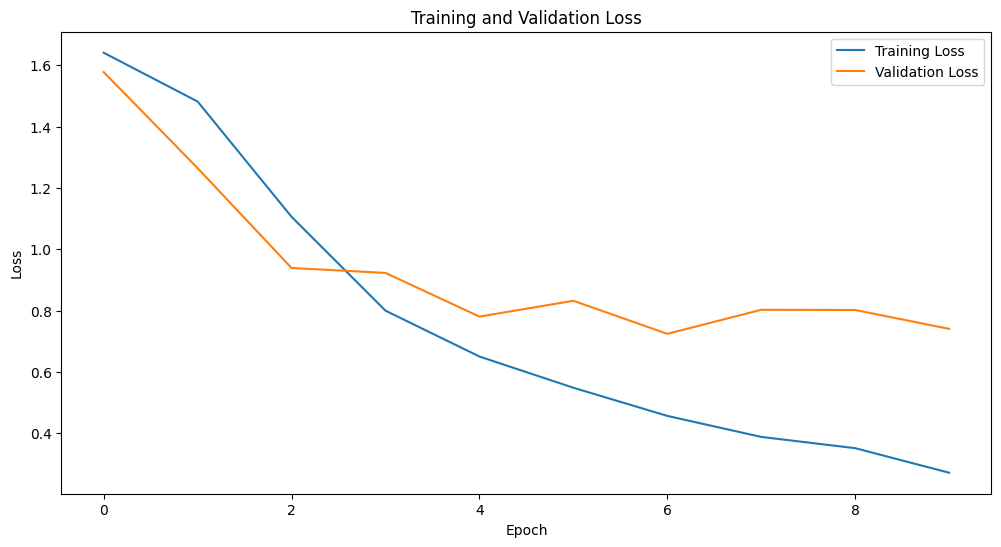

In [24]:
# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## BERT ##

In [28]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [29]:
print(train.columns)
print(val.columns)
print(test.columns)


Index(['Text', 'Emotion', 'text', 'N_label'], dtype='object')
Index(['Text', 'Emotion', 'text', 'N_label'], dtype='object')
Index(['Text', 'Emotion', 'text', 'N_label'], dtype='object')


In [30]:
train["text"] = train["Text"].apply(preprocess)
val["text"] = val["Text"].apply(preprocess)
test["text"] = test["Text"].apply(preprocess)


In [31]:
# Check the columns again
print(train.columns)
print(val.columns)
print(test.columns)

Index(['Text', 'Emotion', 'text', 'N_label'], dtype='object')
Index(['Text', 'Emotion', 'text', 'N_label'], dtype='object')
Index(['Text', 'Emotion', 'text', 'N_label'], dtype='object')


In [32]:
train_encodings = encode_data(train["text"], tokenizer, max_len)
val_encodings = encode_data(val["text"], tokenizer, max_len)
test_encodings = encode_data(test["text"], tokenizer, max_len)


In [33]:
from sklearn import preprocessing

# Encode labels for training, validation, and test sets
label_encoder = preprocessing.LabelEncoder()

# Create 'N_label' columns
train["N_label"] = label_encoder.fit_transform(train["Emotion"])
val["N_label"] = label_encoder.transform(val["Emotion"])  # Use the same encoder
test["N_label"] = label_encoder.transform(test["Emotion"])  # Use the same encoder


In [34]:
print(train.head())
print(val.head())
print(test.head())


                                                Text  Emotion  \
0                            i didnt feel humiliated  sadness   
1  i can go from feeling so hopeless to so damned...  sadness   
2   im grabbing a minute to post i feel greedy wrong    anger   
3  i am ever feeling nostalgic about the fireplac...     love   
4                               i am feeling grouchy    anger   

                                                text  N_label  
0                                  didnt feel humili        4  
1  go feel hopeless damn hope around someon care ...        4  
2               im grab minut post feel greedi wrong        0  
3     ever feel nostalg fireplac know still properti        3  
4                                       feel grouchi        0  
                                                Text  Emotion  \
0  im feeling quite sad and sorry for myself but ...  sadness   
1  i feel like i am still looking at a blank canv...  sadness   
2                     i feel l

In [35]:
y_train = train["N_label"].values
y_val = val["N_label"].values
y_test = test["N_label"].values


In [36]:
from transformers import BertTokenizer

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize and encode data
def encode_data(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

max_len = 128  # Maximum sequence length

# Tokenize and encode data
train_encodings = encode_data(train["text"], tokenizer, max_len)
val_encodings = encode_data(val["text"], tokenizer, max_len)
test_encodings = encode_data(test["text"], tokenizer, max_len)

# Prepare input dictionaries for the model
X_train = {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]}
X_val = {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]}
X_test = {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]}


In [37]:
from transformers import TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow as tf

# Define maximum sequence length
max_len = 128  # or any value you choose based on your tokenizer configuration

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Define input layers
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Extract embeddings from BERT
bert_output = bert_model(input_ids, attention_mask=attention_mask)[1]  # Use pooled output

# Add classification layers
x = Dense(128, activation="relu")(bert_output)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Build and compile the model
model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [2]:
history = model.fit(
    x={"input_ids": X_train["input_ids"], "attention_mask": X_train["attention_mask"]},
    y=y_train,
    validation_data=(
        {"input_ids": X_val["input_ids"], "attention_mask": X_val["attention_mask"]},
        y_val
    ),
    epochs=3,
    batch_size=16  
)

NameError: name 'model' is not defined

# Hybrid CNN + RNN Model

Combines the power of **CNNs** for feature extraction with **RNNs** (LSTMs/GRUs) for sequence modeling. 
This architecture captures both local and sequential patterns in the text data.

### Model Architecture
- **Embedding Layer**: Converts text into dense vector representations.
- **Convolutional Layers**: Extract local features and n-gram-like patterns.
- **MaxPooling Layers**: Downsample feature maps to reduce dimensions.
- **GRU Layers**: Handle sequential dependencies and capture context in the text.
- **Dense Layers**: Perform classification using the extracted features.
- **Output Layer**: Softmax activation for multi-class classification.




In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
model.add(Conv1D(128, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(GRU(128, activation="tanh", return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64, activation="tanh"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation="softmax"))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 128)          0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 49, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 49, 128)           99072     
                                                                 
 dropout_4 (Dropout)         (None, 49, 128)           0         
                                                      

In [25]:
# Train the Model
history = model.fit(
    X_train, y_train,  # Use your existing training data
    validation_data=(X_val, y_val),  # Use your validation data
    epochs=10,  # Adjust based on your resources
    batch_size=32,  # Modify as per your system capacity
    verbose=1  # Enable detailed progress
)


Epoch 1/10
500/500 [==============================] - 26s 53ms/step - loss: 0.2318 - accuracy: 0.9352 - val_loss: 0.7663 - val_accuracy: 0.7960
Epoch 2/10
500/500 [==============================] - 25s 50ms/step - loss: 0.2171 - accuracy: 0.9385 - val_loss: 0.8163 - val_accuracy: 0.8025
Epoch 3/10
500/500 [==============================] - 26s 52ms/step - loss: 0.1959 - accuracy: 0.9434 - val_loss: 0.8820 - val_accuracy: 0.7915
Epoch 4/10
500/500 [==============================] - 32s 65ms/step - loss: 0.1867 - accuracy: 0.9487 - val_loss: 0.8829 - val_accuracy: 0.7935
Epoch 5/10
500/500 [==============================] - 27s 54ms/step - loss: 0.1752 - accuracy: 0.9533 - val_loss: 0.9137 - val_accuracy: 0.8015
Epoch 6/10
500/500 [==============================] - 25s 51ms/step - loss: 0.1680 - accuracy: 0.9524 - val_loss: 0.8872 - val_accuracy: 0.8020
Epoch 7/10
500/500 [==============================] - 25s 51ms/step - loss: 0.1588 - accuracy: 0.9557 - val_loss: 0.9319 - val_accuracy:

In [26]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


63/63 [==============================] - 1s 15ms/step - loss: 0.9716 - accuracy: 0.7880
Test Accuracy: 78.80%


63/63 [==============================] - 1s 16ms/step


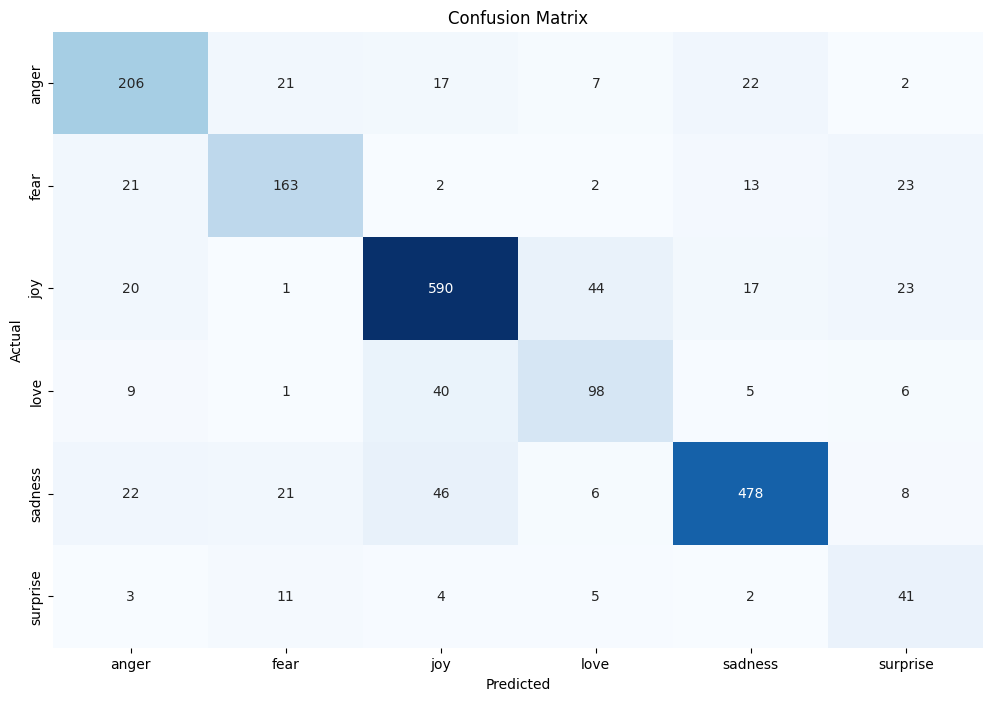

              precision    recall  f1-score   support

       anger       0.73      0.75      0.74       275
        fear       0.75      0.73      0.74       224
         joy       0.84      0.85      0.85       695
        love       0.60      0.62      0.61       159
     sadness       0.89      0.82      0.86       581
    surprise       0.40      0.62      0.49        66

    accuracy                           0.79      2000
   macro avg       0.70      0.73      0.71      2000
weighted avg       0.80      0.79      0.79      2000



In [27]:
# Predict on Test Data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Display Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


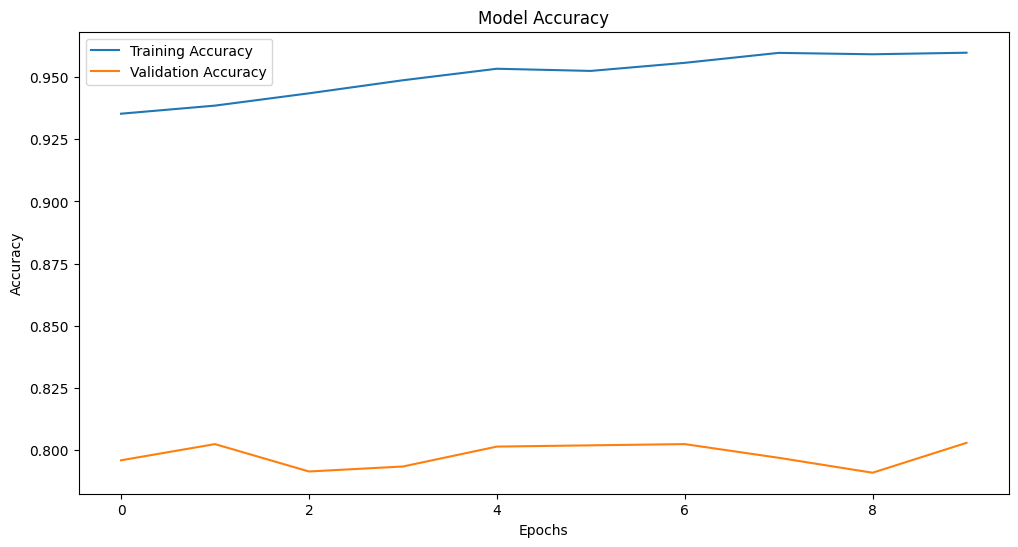

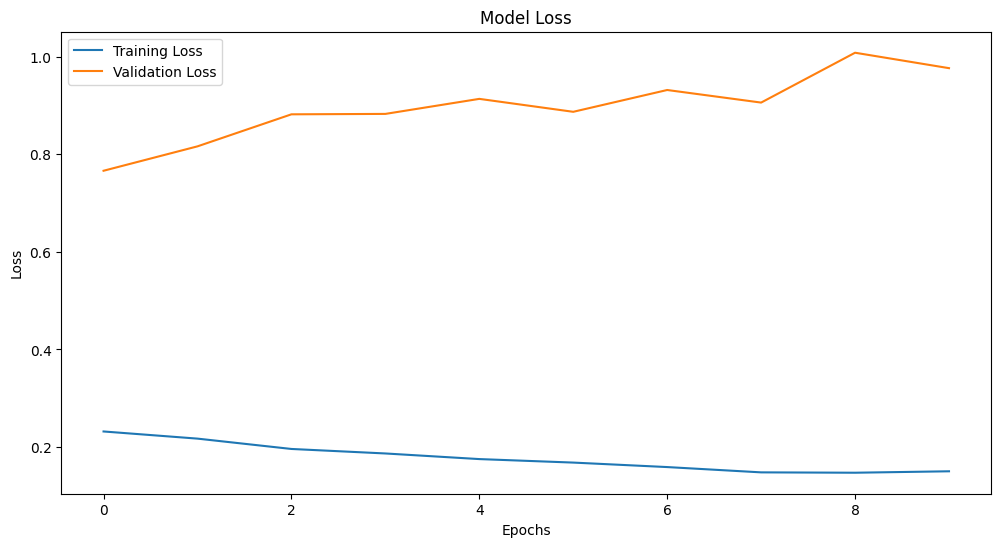

In [28]:
# Accuracy Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GRU, SimpleRNN, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import random

# Define the hyperparameter search space
param_space = {
    "learning_rate": [1e-2, 1e-3, 1e-4],
    "filters": [64, 128, 256],
    "kernel_size": [3, 5],
    "dropout_rate": [0.3, 0.5],
    "rnn_units": [64, 128],
    "batch_size": [16, 32, 64],
    "epochs": [5, 10, 20]
}

# Function to build a model
def build_model(params, model_type="hybrid"):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
    
    if model_type == "cnn":
        # CNN-specific layers
        model.add(Conv1D(params["filters"], kernel_size=params["kernel_size"], activation="relu"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(params["dropout_rate"]))
        model.add(Flatten())
    elif model_type == "rnn":
        # RNN-specific layers
        model.add(SimpleRNN(params["rnn_units"], return_sequences=True, activation="tanh"))
        model.add(Dropout(params["dropout_rate"]))
        model.add(SimpleRNN(params["rnn_units"] // 2, activation="tanh"))
    elif model_type == "hybrid":
        # Hybrid CNN + GRU layers
        model.add(Conv1D(params["filters"], kernel_size=params["kernel_size"], activation="relu"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(params["dropout_rate"]))
        model.add(GRU(params["rnn_units"], return_sequences=True, activation="tanh"))
        model.add(Dropout(params["dropout_rate"]))
        model.add(GRU(params["rnn_units"] // 2, activation="tanh"))

    # Fully connected layers
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(params["dropout_rate"]))
    model.add(Dense(len(label_encoder.classes_), activation="softmax"))
    
    optimizer = Adam(learning_rate=params["learning_rate"])
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Random Search
results = []
for i in range(10):  # Run random search 10 times
    params = {key: random.choice(value) for key, value in param_space.items()}
    print(f"Testing configuration: {params}")
    model = build_model(params, model_type="hybrid")  # Choose model type: "cnn", "rnn", or "hybrid"
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=0  # Suppress training logs for brevity
    )
    
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    results.append((params, val_loss, val_accuracy))
    print(f"Validation Accuracy: {val_accuracy:.4f}")

# Find the best configuration
best_config = max(results, key=lambda x: x[2])  # Sort by validation accuracy
print(f"Best Configuration: {best_config[0]}")
print(f"Validation Accuracy: {best_config[2]:.4f}")


Testing configuration: {'learning_rate': 0.001, 'filters': 64, 'kernel_size': 5, 'dropout_rate': 0.5, 'rnn_units': 128, 'batch_size': 64, 'epochs': 5}
Validation Accuracy: 0.3520
Testing configuration: {'learning_rate': 0.01, 'filters': 128, 'kernel_size': 5, 'dropout_rate': 0.5, 'rnn_units': 128, 'batch_size': 64, 'epochs': 20}
Validation Accuracy: 0.3520
Testing configuration: {'learning_rate': 0.001, 'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.5, 'rnn_units': 128, 'batch_size': 64, 'epochs': 5}
Validation Accuracy: 0.3520
Testing configuration: {'learning_rate': 0.0001, 'filters': 128, 'kernel_size': 5, 'dropout_rate': 0.3, 'rnn_units': 64, 'batch_size': 32, 'epochs': 10}
Validation Accuracy: 0.3520
Testing configuration: {'learning_rate': 0.001, 'filters': 256, 'kernel_size': 5, 'dropout_rate': 0.5, 'rnn_units': 64, 'batch_size': 16, 'epochs': 10}
Validation Accuracy: 0.3520
Testing configuration: {'learning_rate': 0.01, 'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.5, 